In [1]:
import logging
import warnings
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

from time import time
from pathlib import Path
from collections import defaultdict

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
cores = multiprocessing.cpu_count()

In [3]:
input = './data/models/corpus.csv.xz'
df = pd.read_csv(input, header=None, compression='xz')
df

,0
0,isol complex polynomi root algebra algorithm u...
1,algebra algorithm isol complex polynomi zero u...
2,use comput algebra chebyshev polynomi count po...
3,review sacarweb design base discount usabl engin
4,extend immers learn environ hybrid remot virtu...
...,...
129232,dss multipl dimens risk evalu ga pipelin
129233,mcda applic select brazilian fruit best suit f...
129234,applic mcdm model supplier select problem
129235,multicriteria multiobject model risk reliabl m...


In [18]:
sent = [row.split() for row in df[0]]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 04:29:50: collecting all words and their counts
INFO - 04:29:50: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 04:29:50: PROGRESS: at sentence #10000, processed 86473 words and 68433 word types
INFO - 04:29:50: PROGRESS: at sentence #20000, processed 174237 words and 123617 word types
INFO - 04:29:50: PROGRESS: at sentence #30000, processed 262630 words and 174659 word types
INFO - 04:29:51: PROGRESS: at sentence #40000, processed 351260 words and 222475 word types
INFO - 04:29:51: PROGRESS: at sentence #50000, processed 436780 words and 263769 word types
INFO - 04:29:51: PROGRESS: at sentence #60000, processed 514049 words and 293664 word types
INFO - 04:29:51: PROGRESS: at sentence #70000, processed 592750 words and 322540 word types
INFO - 04:29:52: PROGRESS: at sentence #80000, processed 672385 words and 350709 word types
INFO - 04:29:52: PROGRESS: at sentence #90000, processed 751449 words and 378133 word types
INFO - 04:29:52: PROGRESS: at sentence #1

In [21]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

print(len(word_freq))
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

47956
['use', 'base', 'system', 'model', 'analysi', 'network', 'approach', 'applic', 'data', 'method']


In [22]:
model = Word2Vec(min_count=20, window=2, size=300, sample=6e-5,
                 alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

In [25]:
t = time()
model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 04:33:36: collecting all words and their counts
INFO - 04:33:36: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 04:33:37: PROGRESS: at sentence #10000, processed 81417 words, keeping 12398 word types
INFO - 04:33:37: PROGRESS: at sentence #20000, processed 164163 words, keeping 18848 word types
INFO - 04:33:37: PROGRESS: at sentence #30000, processed 247499 words, keeping 24128 word types
INFO - 04:33:38: PROGRESS: at sentence #40000, processed 331206 words, keeping 28826 word types
INFO - 04:33:38: PROGRESS: at sentence #50000, processed 411591 words, keeping 32653 word types
INFO - 04:33:39: PROGRESS: at sentence #60000, processed 483674 words, keeping 34705 word types
INFO - 04:33:39: PROGRESS: at sentence #70000, processed 557140 words, keeping 36596 word types
INFO - 04:33:39: PROGRESS: at sentence #80000, processed 631592 words, keeping 38714 word types
INFO - 04:33:40: PROGRESS: at sentence #90000, processed 705403 words, keeping 40538 word types

In [26]:
t = time()
model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

OGRESS: at 49.16% examples, 76718 words/s, in_qsize 0, out_qsize 0
INFO - 04:35:26: EPOCH 7 - PROGRESS: at 71.15% examples, 80239 words/s, in_qsize 0, out_qsize 0
INFO - 04:35:27: EPOCH 7 - PROGRESS: at 91.80% examples, 81491 words/s, in_qsize 0, out_qsize 0
INFO - 04:35:27: worker thread finished; awaiting finish of 2 more threads
INFO - 04:35:27: worker thread finished; awaiting finish of 1 more threads
INFO - 04:35:27: worker thread finished; awaiting finish of 0 more threads
INFO - 04:35:27: EPOCH - 7 : training on 998520 raw words (450766 effective words) took 5.5s, 81798 effective words/s
INFO - 04:35:28: EPOCH 8 - PROGRESS: at 14.15% examples, 65126 words/s, in_qsize 1, out_qsize 0
INFO - 04:35:29: EPOCH 8 - PROGRESS: at 31.73% examples, 75479 words/s, in_qsize 0, out_qsize 0
INFO - 04:35:30: EPOCH 8 - PROGRESS: at 47.04% examples, 71782 words/s, in_qsize 0, out_qsize 0
INFO - 04:35:31: EPOCH 8 - PROGRESS: at 64.91% examples, 72345 words/s, in_qsize 0, out_qsize 0
INFO - 04:35:3

### T-SNE Plot

In [41]:
def tsnescatterplot(model, word, list_names):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality
    reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

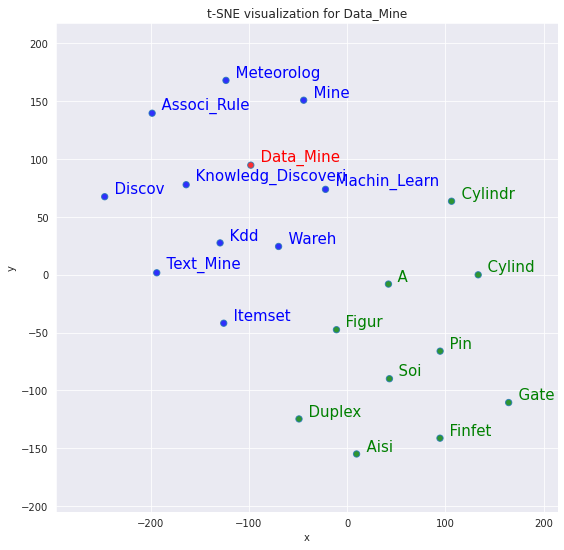

In [45]:
# 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(model, 'data_mine', [i[0] for i in model.wv.most_similar(negative=["data_mine"])])

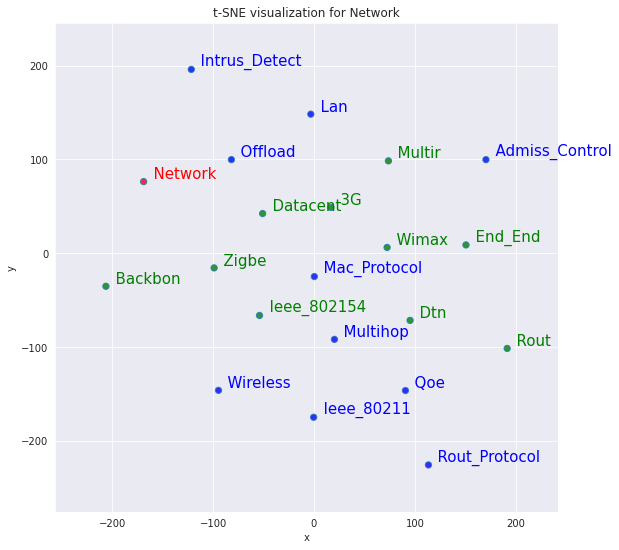

In [46]:
#10 Most similar words vs. 11th to 20th Most similar words:
tsnescatterplot(model, "network", [t[0] for t in model.wv.most_similar(positive=["network"], topn=20)][10:])

In [47]:
path = './data/models/'
Path(path).mkdir(exist_ok=True)
model_file = '%sword2vec.model' % path

model.wv.save_word2vec_format(model_file, binary=True)

INFO - 05:02:41: storing 5103x300 projection weights into ./data/models/word2vec.model
